<a href="https://colab.research.google.com/github/pachterlab/LSCHWCP_2023/blob/main/Notebooks/Figure_8/Figure_8a/viral_profiles_over_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Viral profiles over time

In [ ]:
!pip install -q anndata
import anndata
import numpy as np
import random
import pandas as pd
import json
import os
import glob
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

def nd(arr):
    """
    Function to transform numpy matrix to nd array.
    """
    return np.asarray(arr).reshape(-1)

def flatten(xss):
    """
    Function to flatten array of arrays.
    """
    return [x for xs in xss for x in xs]

def rand_jitter(arr, jitter_size=0.02):
    """
    Add random jitter to array to avoid overplotting.
    """
    return np.random.uniform(low=-jitter_size, high=jitter_size, size=(len(arr),))

# Load data

The count matrix was generated [here](https://github.com/pachterlab/LSCHWCP_2023/tree/main/Notebooks/align_macaque_PBMC_data/7_virus_host_captured_dlist_cdna_dna).

In [ ]:
# Download count matrix from Caltech data
!wget https://data.caltech.edu/records/sh33z-hrx98/files/virus_host-captured_dlist_cdna_dna.h5ad?download=1
!mv virus_host-captured_dlist_cdna_dna.h5ad?download=1 virus_host-captured_dlist_cdna_dna.h5ad

In [ ]:
palmdb_adata = anndata.read("virus_host-captured_dlist_cdna_dna.h5ad")
palmdb_adata

AnnData object with n_obs × n_vars = 225898 × 11176
    obs: 'sample_barcode', 'srr', 'Run', 'donor_animal', 'Experiment', 'mdck_spike_in', 'hours_post_innoculation', 'day_post_infection', 'dpi', 'dpi_accessions', 'dpi_clean', 'leiden', 'celltype_clusters', 'celltype', 'species', 'dpi_clean_merged'
    var: 'v_type'

#### Load ID to taxonomy mapping

In [ ]:
# Load virus ID to taxonomy mapping
!wget https://raw.githubusercontent.com/pachterlab/LSCHWCP_2023/main/PalmDB/ID_to_taxonomy_mapping.csv
phylogeny_data = pd.read_csv("ID_to_taxonomy_mapping.csv")

# Drop columns not needed here
phylogeny_data = phylogeny_data.drop("ID", axis=1).drop("strandedness", axis=1).drop_duplicates()
phylogeny_data

,rep_ID,phylum,class,order,family,genus,species
0,u1,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...
409,u10,Negarnaviricota,Monjiviricetes,Mononegavirales,Filoviridae,Ebolavirus,Zaire ebolavirus
475,u100,Kitrinoviricota,Flasuviricetes,Amarillovirales,Flaviviridae,Flavivirus,West Nile virus
590,u102,Kitrinoviricota,Alsuviricetes,Hepelivirales,Hepeviridae,Orthohepevirus,Orthohepevirus A
909,u113,Negarnaviricota,Monjiviricetes,Mononegavirales,Paramyxoviridae,Morbillivirus,Measles morbillivirus
...,...,...,...,...,...,...,...
296556,u296608,.,.,.,.,.,.
296557,u296609,.,.,.,.,.,.
296558,u296613,.,.,.,.,.,.
296559,u296616,.,.,.,.,.,.


___

### Compare virus profiles from the same animal between two samples taken at different time points

In [ ]:
# Macaque only and shared viruses in the same order as shown in Fig. 6d
virs = [
    # Macaque only
    'u39566', 'u102540', 'u11150', 'u10',
    # Shared
    'u288819',
    'u290519',
    'u10240',
    'u183255',
    'u1001',
    'u100291',
    'u103829',
    'u110641',
    'u181379',
    'u202260',
    'u135858',
    'u101227',
    'u100188',
    'u27694',
    'u34159',
    'u100245',
    'u10015',
    'u100733',
    'u100173',
    'u100196',
    'u100599',
    'u100644',
    'u100296',
    'u100017',
    'u100002',
    'u100012',
    'u100024',
    'u100048',
    'u100302',
    'u100074',
    'u100289',
    'u100026',
    'u100111',
    'u100139',
    'u100154',
    'u100251',
    'u100177',
    'u100215',
    'u100049',
    'u100000',
    'u100001',
    'u100007',
    'u100004',
    'u100011',
    'u100093',
    'u100116',
    'u100019',
    'u100076',
    'u100028',
    'u100153',
    'u100031',
    'u100145',
    'u102324',
    'u134800'
]

In [ ]:
# Sort animal IDs by difference in time
animal_ids_sorted = [
    # 20 hours apart
    'NHP1',
    'NHP2',
    # 3 days apart
    'NHP13',
    'NHP14',
    'NHP15',
    # 5 days apart
    'NHP16',
    'NHP17',
    'NHP18',
    # 10 days apart
    'NHP08',
    'NHP11',
    # 11 days apart
    'NHP10',
    # 12 days apart
    'NHP09',
    # 36 days apart
    'NHP23',
]

time_difs = [
    "20h",
    "20h",
    "3d",
    "3d",
    "3d",
    "5d",
    "5d",
    "5d",
    "10d",
    "10d",
    "11d",
    "12d",
    "36d",
]

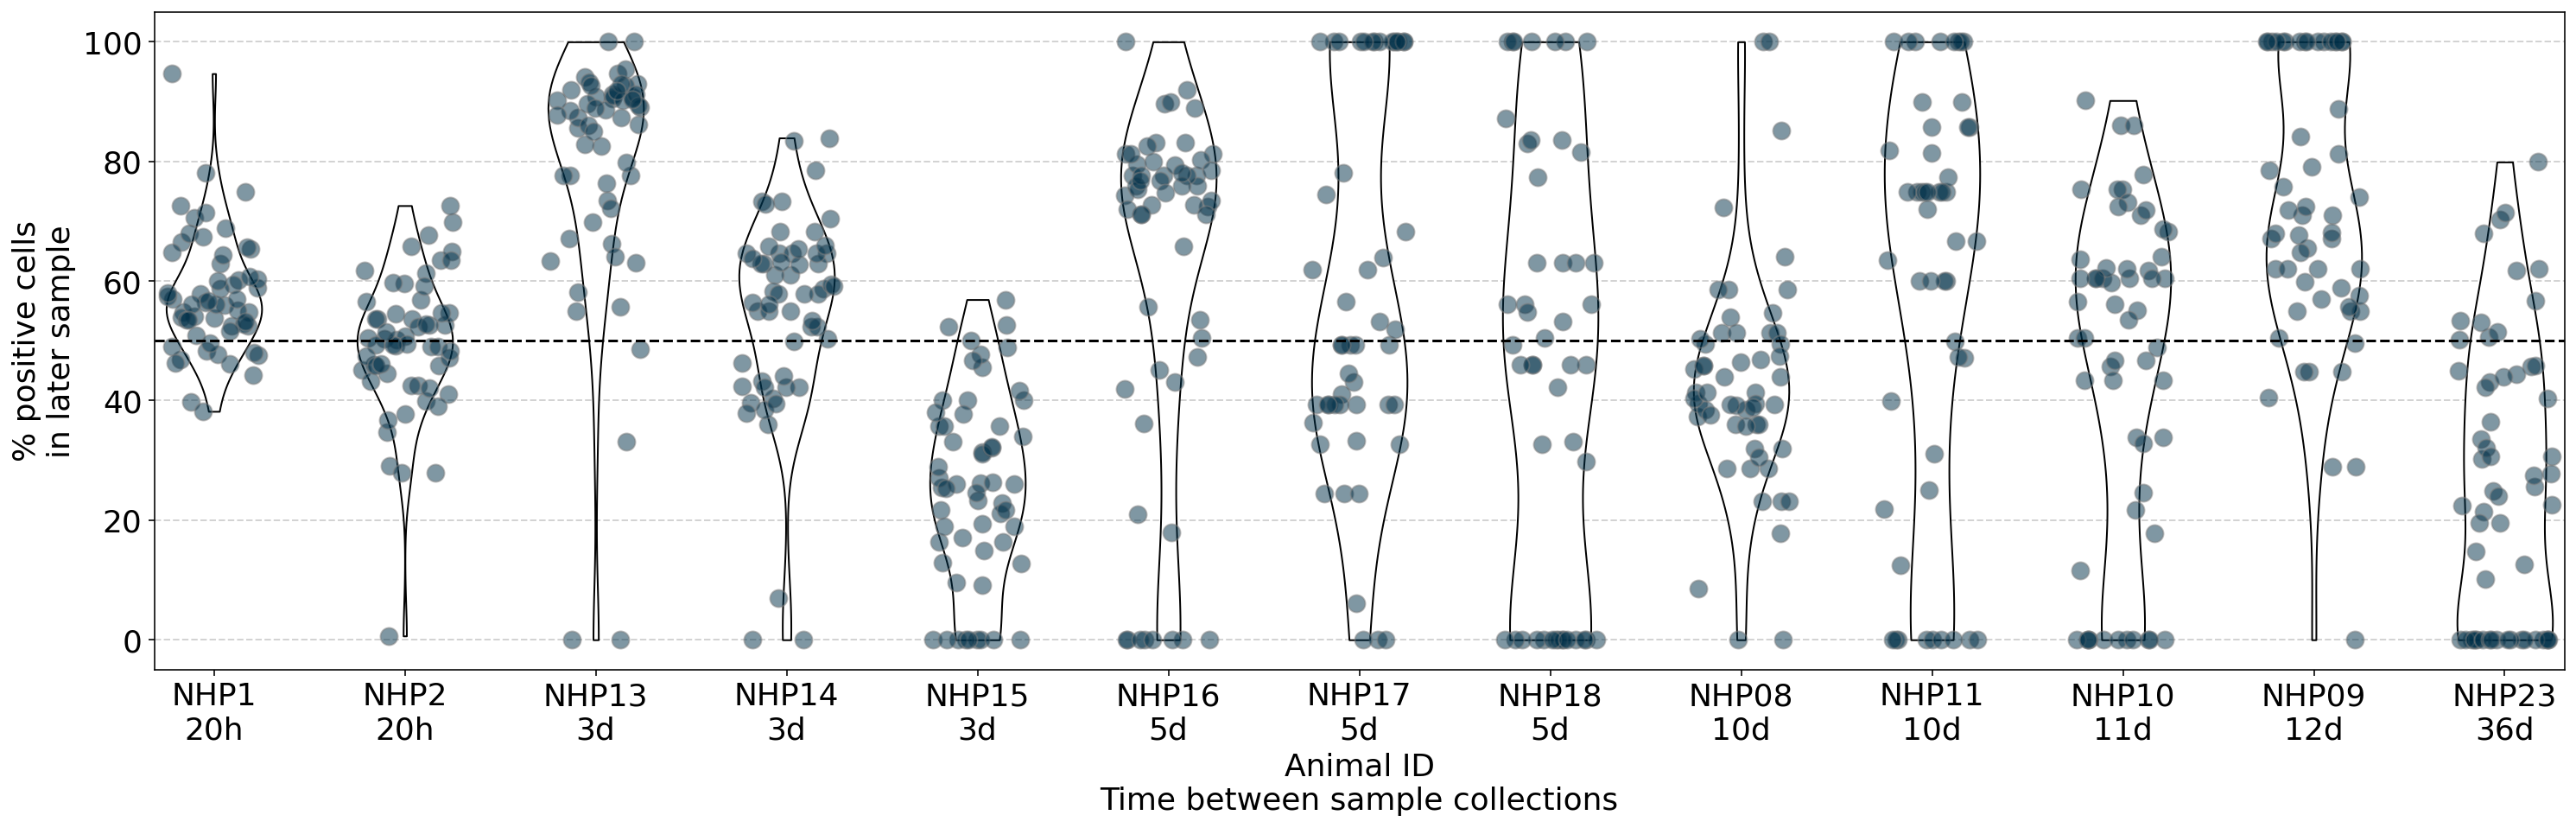

In [ ]:
fig, ax = plt.subplots(figsize=(25,7))
fontsize = 18

s=100
width=0.5
color = "#003049" # Change to #b266b3 for black bkg
background = "white"
label_color = "black"
grid_color = "lightgrey"

x = 0
for animal_id in animal_ids_sorted:
    fcs = []
    first_frac = []
    second_frac = []
    for vir in virs:
        # Collect positive cells per time point
        pos_cells = []
        for tp in palmdb_adata.obs[palmdb_adata.obs["donor_animal"] == animal_id]["dpi_clean_merged"].unique():
            # Get positive cell count
            posc = palmdb_adata[(palmdb_adata.obs["dpi_clean_merged"] == tp) & (palmdb_adata.obs["donor_animal"] == animal_id), palmdb_adata.var.index.values == vir].X.sum()

            # Normalize to total number of cells
            total_num_cells = len(palmdb_adata.obs[(palmdb_adata.obs["dpi_clean_merged"] == tp) & (palmdb_adata.obs["donor_animal"] == animal_id)])
            norm_count = posc / total_num_cells

            pos_cells.append(norm_count)

        if pos_cells[0] > 0 or pos_cells[1] > 0:
            # Calculate fold change between time points
            # fcs.append((pos_cells[1]-pos_cells[0]) / pos_cells[0])

            # Calculate total positive cell difference between time points
            # fcs.append(pos_cells[1] - pos_cells[0])

            # Fraction occupied by second timepoint
            fcs.append(pos_cells[1]/(pos_cells[0] + pos_cells[1]))

    # Convert fractions to percentages
    fcs = np.array(fcs)*100

    v = ax.violinplot(fcs, [x], widths=width, vert=True, showmedians=False, showextrema=False)
    for pcidx, pc in enumerate(v["bodies"]):
        pc.set_facecolor(background)
        pc.set_edgecolor(label_color)
        pc.set_alpha(1)
    ax.scatter([x]*len(fcs) + rand_jitter([x]*len(fcs), width/2), fcs, alpha=0.5, color=color, edgecolor="grey", s=s)
    x += 1

ax.grid(True, which="both", color=grid_color, ls="--", lw=1)
ax.set_axisbelow(True)
ax.xaxis.grid(False)

labels = []
for animal, time_dif in zip(animal_ids_sorted, time_difs):
    labels.append(f"{animal}\n{time_dif}")

ax.set_xticks(np.arange(len(animal_ids_sorted)), labels, fontsize=fontsize)
ax.tick_params(axis="both", labelsize=fontsize)
ax.margins(x=0.005)

ax.axhline(50, c="black", ls="--", lw=1.5)

# ax.set_ylim(-ax.get_ylim()[1], ax.get_ylim()[1])
# ax.set_ylim(-100, 100)

# ax.set_ylabel("Δ positive cells\nbetween time points", fontsize=fontsize)
ax.set_ylabel("% positive cells\nin later sample", fontsize=fontsize)
ax.set_xlabel("Animal ID\nTime between sample collections", fontsize=fontsize)

plt.savefig("dif_vir_counts_across_tps.png", dpi=300, bbox_inches="tight")

fig.show()